# Smartphone Battery Life Predictor
An ML model for prediction how much time a phone battery has left before it is depleted.

By: Mats van Liempd

Version: 2.1.0

In [62]:
import sklearn as skl
import numpy as np
import matplotlib as mpl
import seaborn as sb
import pandas as pd

#### Importing The Dataset

In [63]:
data = pd.read_csv("datasets/Data Collection Smartphone Battery Life(Sheet1)_with_capacity_with_estimated_life.csv")
data.head()
data.sort_values(by="sessionlength", ascending=False)

,Id,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
30,31,23,Man,iPhone 15,iOs,100,100,39,21663,No,6,45,Yes,No,No,No,3349,35513.0
32,33,22,Prefer not to say,Samsung Galaxy S23,Android,100,100,43,21663,No,6,45,Yes,No,No,No,3900,38005.0
31,32,22,Prefer not to say,Google Pixel 8,Android,100,100,44,21663,No,6,45,Yes,No,No,No,4575,38684.0
12,13,24,Man,iPhone 16,iOs,100,100,64,18034,No,4,100,Yes,No,No,No,3561,50094.0
13,14,25,Man,Samsung Galaxy S25 Ultra,Android,100,100,69,18034,No,4,100,Yes,No,No,No,5000,58174.0
11,12,26,Man,iPhone 16 Pro Max,iOs,100,100,71,18034,No,4,100,Yes,No,No,No,4685,62186.0
7,8,26,Man,iPhone 17 Pro Max,iOs,100,100,73,18034,No,4,100,Yes,No,No,No,5088,66793.0
9,10,25,Man,iPhone Air,iOs,100,100,51,18034,No,4,100,Yes,No,No,No,3149,36804.0
8,9,26,Man,iPhone 17 Pro,iOs,100,100,66,18034,No,4,100,Yes,No,No,No,4252,53041.0
10,11,25,Man,iPhone 17,iOs,100,100,64,18034,No,4,100,Yes,No,No,No,3692,50094.0


#### Data Cleaning
Making the data usable with actual models

In [64]:
df = pd.DataFrame(data)
df = df.drop(columns=["Id"])

 
# change phoneos to 0 (iOs) and 1 (Android) 
df["phoneos"] = df["phoneos"].str.strip().str.lower().map({
    "ios": 0,
    "android": 1
})

# change all yes/no collumns in the data set to 1/0 booleans
yes_no_cols = [
    col for col in df.columns
    if df[col].astype(str).str.lower().isin(["yes", "no"]).any() and col != "phoneos"
]

for col in yes_no_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        "yes": 1,
        "no": 0
    })

# converting gender options to numerical values
df["usergender"] = df["usergender"].str.strip().str.lower().map({
    "man": 0,
    "woman": 1,
    "non-binary": 2,
    "prefer not to say": 3
})


df.sample(5)

,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
41,23,0,Samsung A35,1,100,71,70,600,1,3,40,1,1,1,1,5000,42600.0
18,19,0,Iphone 13,0,80,46,42,942,0,4,50,1,0,1,0,3227,10833.0
20,27,0,iPhone 13 Pro,0,77,71,67,740,1,1,100,1,1,1,0,3095,13135.0
42,56,0,iPhone 16e,0,99,97,92,2800,0,21,50,1,0,0,0,3561,54320.0
13,25,0,Samsung Galaxy S25 Ultra,1,100,100,69,18034,0,4,100,1,0,0,0,5000,58174.0


#### Feature Selection

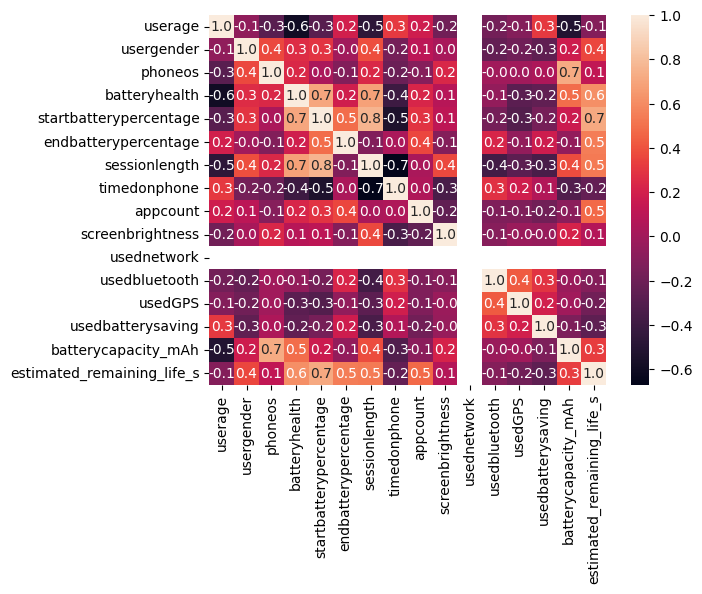

In [65]:
# correlations = df.corr()
correlations = df.select_dtypes(include='number').corr()
plot = sb.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

a lot of possibly usefull features spotted, im happy

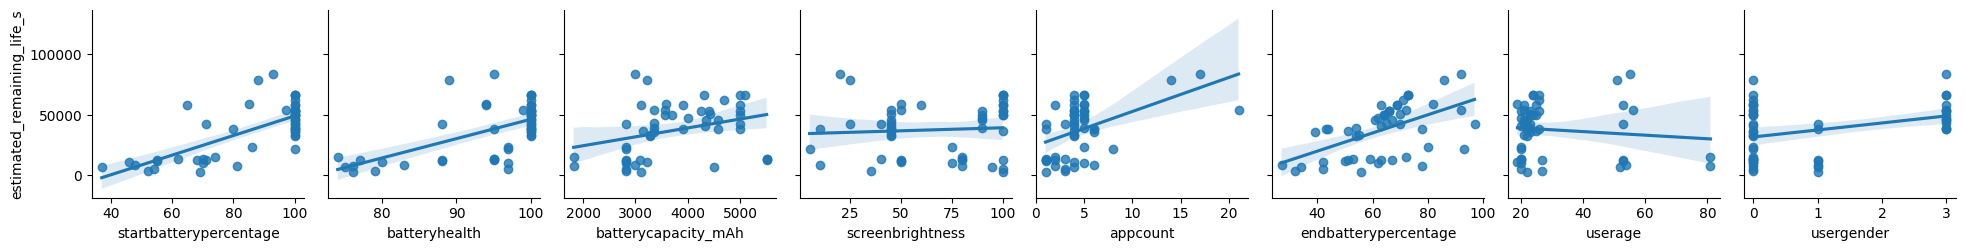

In [66]:
candidates = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh", "screenbrightness", "appcount", "endbatterypercentage", "userage", "usergender"]
plot = sb.pairplot(df, x_vars=candidates, y_vars="estimated_remaining_life_s", kind="reg")

i can forsee a possible problem as not all of the data looks as linear as i thought i would look

#### Splitting The Data & Normalization

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#features = [ "startbatterypercentage","batteryhealth", "batterycapacity_mAh", "screenbrightness", "timedonphone", "appcount", "usednetwork", "usedbluetooth", "usedGPS", "usedbatterysaving", "phoneos"] # -> tested all features' performance

features = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh", "screenbrightness", "appcount", "endbatterypercentage"] # -> tested more limited intentionally chosen features' performance

#features = ["startbatterypercentage", "batteryhealth", "batterycapacity_mAh"] # -> tested the minimal features' performance (only the highest correlating features)

target = "estimated_remaining_life_s"
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df['estimated_remaining_life_s'] / 3600

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 51 observations, of which 40 are now in the train set, and 11 in the test set.


#### Training The Model (Linear Regression)

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error

print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.5485109979764171
MAE: 3h 20m 34s (12034.586590733696)


linear is NOT working ;-; -> conclusion: data is not linear

### Testing other possible models

#### Random Forest Regressor

In [69]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error
print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.5709886155093145
MAE: 2h 44m 49s (9889.869090909084)


this is definitely an improvement over the linear model, but 2 and a half hours off is still a lot and not at all what I want.

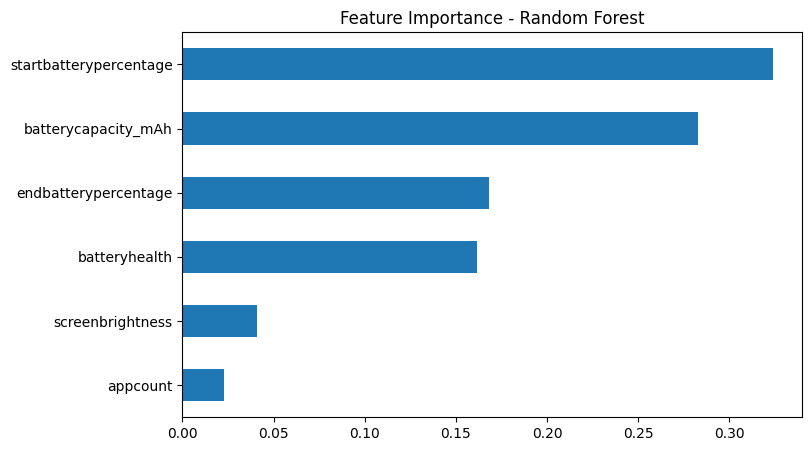

In [70]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Random Forest")
plt.show()

the feature importance seems quite logical and good :D

#### Gradient Boosting Regressor

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)
# model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42) # -> weaker results
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) * 3600 # non scaled mean absolute error
print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.5067155098850069
MAE: 2h 34m 20s (9260.535466898025)


Very good results compared to the other 2 models so ill be going with this one :)

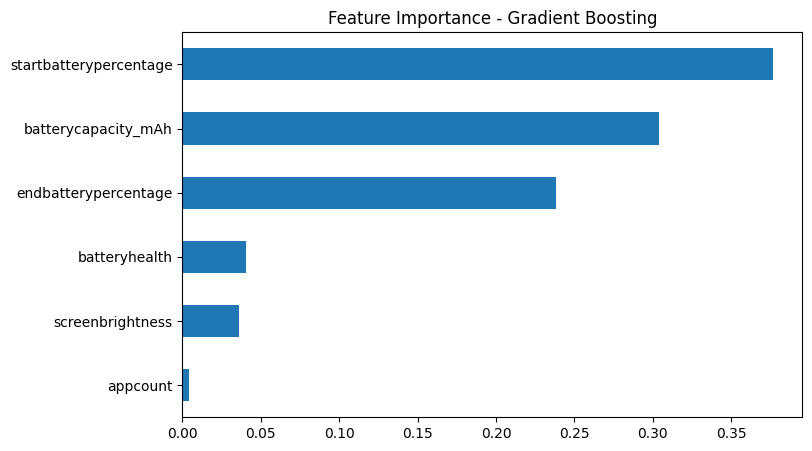

In [72]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Gradient Boosting")
plt.show()

the feature importance seems incredibly skewed.

### Conclusion Iteration 0
From now on I will be using the Gradient Boosting Regressor as it is already yielding the highest results. I also will need way more data for the Mean Absolute Error to go down and actually yield results that can be used, since results that are 1 hour+ off of the actual battery life is just not acceptable. The good thing is that the R² is really close to 1, which means the model is performing well and this is why I assume I need more data for it to properly function.

### Extra Trees Regressor
After Checking 9 Regressor models I concluded Extra Trees as the best

#### Setting up model

In [73]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

#### Performing Cross validation
I forgot this last iteration

In [74]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
cv_r2 = cross_val_score(model, X, y, cv=kf, scoring="r2", n_jobs=-1)

print(f"Cross-Validation MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f} hours")
print(f"Cross-Validation R²:  {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

Cross-Validation MAE: 1.94 ± 0.45 hours
Cross-Validation R²:  0.633 ± 0.120


#### Testing

In [75]:
from sklearn.metrics import r2_score

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred) * 3600  # seconds
r2_test = r2_score(y_test, y_pred)

print("\nTest Set Results:")
print(f"R²: {r2_test:.3f}")
print(f"MAE: {int(mae_test // 3600)}h {int((mae_test % 3600) // 60)}m {int(mae_test % 60)}s ({mae_test:.2f} seconds)")


Test Set Results:
R²: 0.777
MAE: 2h 6m 21s (7581.47 seconds)


#### Feature importance

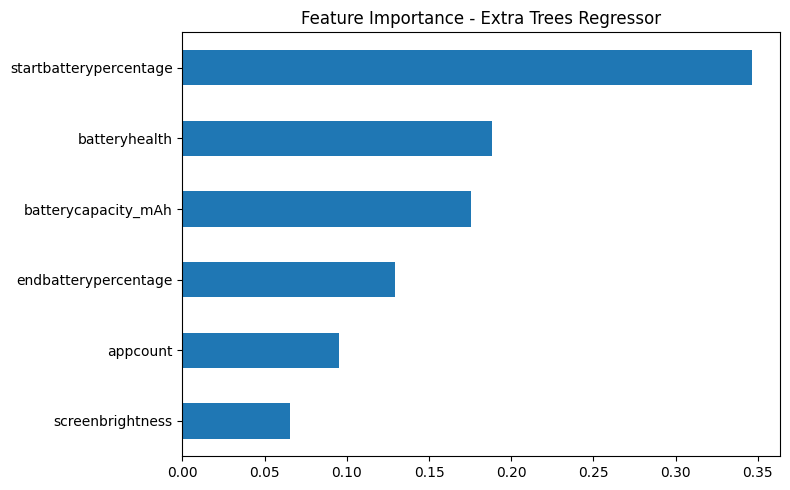

In [76]:
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8, 5))
importance.plot(kind="barh", title="Feature Importance - Extra Trees Regressor")
plt.tight_layout()
plt.show()